
# Punto 2 · Clusterización Funcional de Ventas (Retail)

Este notebook implementa la ruta acordada para el **Punto 2** del parcial:
1) Carga de datos (vistas: *clean*, *zscore*, *normalized*, *minmax*).  
2) Clustering jerárquico (Ward + Euclidiana sobre **z-score**) y comparación con otras métricas (correlación, DTW opcional).  
3) Selección de **k** con Silueta y Davies–Bouldin.  
4) Caracterización de clusters (curvas promedio, “medoides”, bandas).  
5) Asignación de **Tienda_101** y **proyección** de sus 24 meses usando la curva promedio del cluster, **escalada** al `ventas_m24` estimado (Punto 1).  
6) Validación (LOOCV simple).

> **Nota de rutas**: ajusta `BASE_DIR` si corres este notebook en tu repo local.


In [16]:

# %% [setup]
import os
import json
import math
import numpy as np
import pandas as pd

from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler


def find_root(marker="data/clean/punto2"):
    here = Path.cwd().resolve()
    for p in [here, *here.parents]:
        if (p / marker).exists():
            return p
    return here  # fallback si se ejecuta en otra carpeta

PROJECT_ROOT = find_root()
P2_DIR = PROJECT_ROOT / "data" / "clean" / "punto2"
P1_OUT_DIR = PROJECT_ROOT / "modelos" / "outputs_p1"

FN_CLEAN_WIDE = P2_DIR / "Punto2.ventas_funcionales_clean.csv"
FN_ZS_WIDE    = P2_DIR / "Punto2.ventas_funcionales_zscore.csv"
FN_NORM_WIDE  = P2_DIR / "Punto2.ventas_funcionales_normalized.csv"
FN_MM_WIDE    = P2_DIR / "Punto2.ventas_funcionales_minmax01.csv"
FN_META       = P2_DIR / "Punto2.ventas_funcionales_metadata_tienda.csv"
FN_REPR       = P2_DIR / "Punto2.ventas_funcionales_tiendas_representativas.json"

# ¡Aquí estaba el problema!
FN_P1_PRED_NUEVAS = P1_OUT_DIR / "pred_nuevas_tiendas.csv"

print("ROOT:", PROJECT_ROOT)
print("Existe clean?", FN_CLEAN_WIDE.exists())
print("Existe zscore?", FN_ZS_WIDE.exists())
print("Existe normalized?", FN_NORM_WIDE.exists())
print("Existe minmax01?", FN_MM_WIDE.exists())
print("Existe meta?", FN_META.exists())
print("Existe pred_nuevas_tiendas?", FN_P1_PRED_NUEVAS.exists())

ROOT: /home/thechieft/Documentos/ParcialDeFi4
Existe clean? True
Existe zscore? True
Existe normalized? True
Existe minmax01? True
Existe meta? True
Existe pred_nuevas_tiendas? True


## 1) Carga de datos

In [19]:

def load_wide_csv(fn: Path) -> pd.DataFrame:
    df = pd.read_csv(fn)
    df.columns = [str(c) for c in df.columns]

    # ¿archivo ya correcto? (filas=tiendas, columnas=Mes_1..Mes_24)
    looks_wide = any(c.lower().startswith("mes") for c in df.columns)

    # ¿archivo transpuesto? (filas=24 meses, columnas tipo Tienda_1..)
    looks_transposed = (df.shape[0] == 24) and any(str(c).lower().startswith("tienda") for c in df.columns[1:])

    if looks_transposed and not looks_wide:
        # pasa a (filas=tienda, cols=mes)
        df = df.set_index(df.columns[0]).T.reset_index().rename(columns={"index": "tienda"})
        # Estandariza nombres de meses
        month_cols = [c for c in df.columns if c != "tienda"]
        df = df.rename(columns={c: (f"Mes_{c}" if str(c).isdigit() else c) for c in month_cols})

    # Detectar columnas de meses
    month_cols = [c for c in df.columns if c.lower().startswith("mes")]
    if len(month_cols) == 0:
        # fallback: 1ª = id, siguientes 24 = meses
        if df.shape[1] >= 25:
            id_col = df.columns[0]
            month_cols = list(df.columns[1:25])
            df = df.rename(columns={id_col: "tienda"})
        else:
            raise ValueError(f"No se detectaron columnas de meses en {fn}")

    # Asegurar columna 'tienda'
    if "tienda" not in df.columns:
        candidates = [c for c in df.columns if "tienda" in c.lower() or c.lower() == "id" or "store" in c.lower()]
        if candidates:
            df = df.rename(columns={candidates[0]: "tienda"})
        else:
            df.insert(0, "tienda", [f"Tienda_{i+1:03d}" for i in range(len(df))])

    # Ordenar Mes_1..Mes_24
    def month_key(c):
        try:
            return int(str(c).split("_")[-1]) if str(c).lower().startswith("mes") else 9999
        except:
            return 9999
    month_cols = sorted(month_cols, key=month_key)
    return df[["tienda"] + month_cols].copy()


wide_clean = load_wide_csv(FN_CLEAN_WIDE) if FN_CLEAN_WIDE.exists() else None
wide_zs    = load_wide_csv(FN_ZS_WIDE)    if FN_ZS_WIDE.exists() else None
wide_norm  = load_wide_csv(FN_NORM_WIDE)  if FN_NORM_WIDE.exists() else None
wide_mm    = load_wide_csv(FN_MM_WIDE)    if FN_MM_WIDE.exists() else None
meta       = pd.read_csv(FN_META) if FN_META.exists() else None

print("Shapes:",
      "clean", None if wide_clean is None else wide_clean.shape,
      "zscore", None if wide_zs is None else wide_zs.shape,
      "norm", None if wide_norm is None else wide_norm.shape,
      "minmax", None if wide_mm is None else wide_mm.shape)
if meta is not None:
    print("meta", meta.shape)

# Dataset operativo principal para clustering por forma:
wide = wide_zs if wide_zs is not None else wide_clean
assert wide is not None, "No se pudo cargar dataset principal (zscore o clean)."
month_cols = [c for c in wide.columns if c != "tienda"]
X = wide[month_cols].values
ids = wide["tienda"].tolist()

# Mes 24 para referencias
mes24_idx = None
for i, c in enumerate(month_cols):
    if c.lower() in ("mes_24", "24"):
        mes24_idx = i
        break
if mes24_idx is None and len(month_cols) >= 24:
    mes24_idx = 23  # fallback
print("Columna de mes 24 -> idx", mes24_idx, "colname", month_cols[mes24_idx] if mes24_idx is not None else None)


Shapes: clean (100, 25) zscore (100, 25) norm (100, 25) minmax (100, 25)
meta (100, 8)
Columna de mes 24 -> idx 23 colname Mes_24


Elegimos **agrupar por forma (z-score)** para que cada tienda este centrada y escalada asi:

- Quitamos el efecto de la **magnitud** (Las hipertiendas no se comen la distancia)
- Con Euclidiana + Ward, para forman clusters de curvas con **patrones similares** (crecientes, estables, etc.).
- Tambien probaremos la base original para probar la tienda 101 a partir de las ventas_m24 y escalar con la curba promedio del cluster.

## 2) Clustering jerárquico (Ward + Euclidiana) y dendrograma

Recordemos que:

- **Euclidiana**: mide la distancia L2 entre dos curvas tratándolas como vectores de 24 meses. Como estás en z-score por tienda, la magnitud queda neutralizada y la distancia captura sobre todo la forma (suben/bajan igual, estacionalidad, rampas, etc.).
- **Ward** (jerárquico aglomerativo): en cada fusión elige los dos grupos cuya unión **minimiza el incremento de la varianza intra-cluster** (SSE). Resultado: clústeres compactos y “esféricos” en el espacio euclidiano, menos sensibles a encadenamientos raros que otros enlaces.

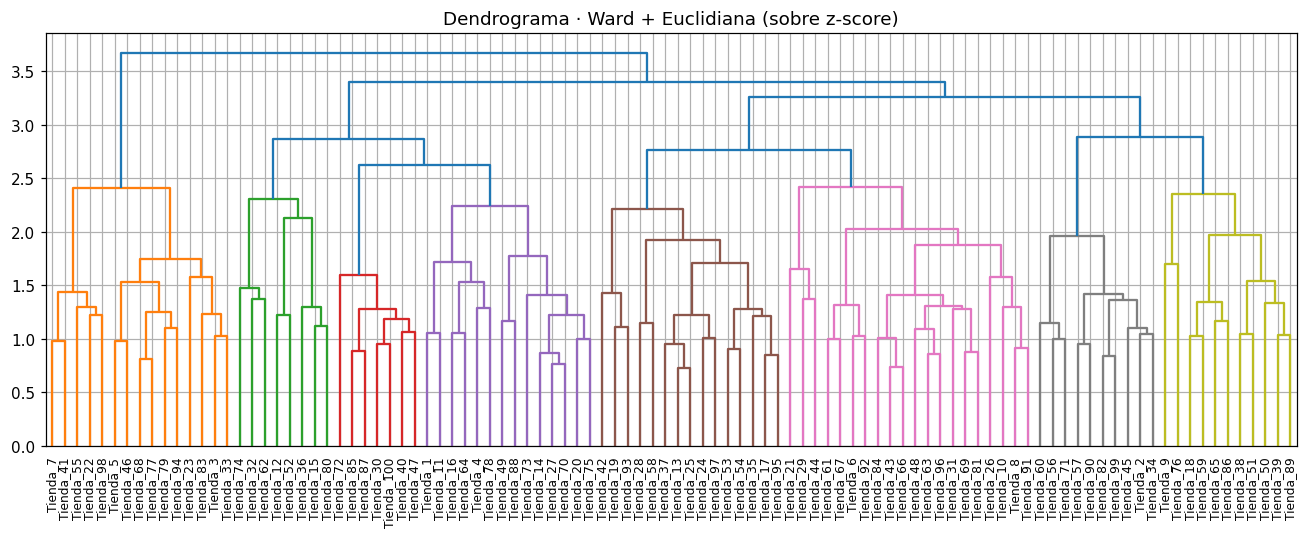

In [20]:

# %% [dendrogram]
# Distancias euclidianas entre curvas (en z-score)
D = pdist(X, metric="euclidean")
Z = linkage(D, method="ward")

plt.figure(figsize=(12, 5))
dendrogram(Z, labels=ids, leaf_rotation=90, leaf_font_size=8, color_threshold=None)
plt.title("Dendrograma · Ward + Euclidiana (sobre z-score)")
plt.tight_layout()
plt.show()


### Análisis del dendograma
Las fuciones son las tiendas o grupos **parecidos** entre más arriba los grupos son **mas distintos**.

Entonces podemos notas que hay un posible **k** entre 5-8 en terminos de mátematicos. Veo Clusteres bastantes **homogeneos** separando bastantes clusteres.

Hablando para el negoció podriamos empezar a ver 3-4 patrones (reduciendo los matematicos) donde validamos lo explorado en el EDA:
1. **Crecientes**
2. **Estables**
3. **Decrecientes/Maduración**
4. **Estacionales marcadas**

y podriamos elgir un micro-cluster para esos **outlayes estrucutrales** que produce ruido alto.

Ahora pasaremos a **cuantificar** el $k$ optimo

## 3) Selección del número de clusters (Silueta, Davies–Bouldin)

In [30]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score


def eval_k_range(Z, X, k_range=range(2, 11), min_cluster_size=3):
    """
    Evalúa k en un rango, devolviendo silueta, DB y estadísticas de tamaño de clúster.
    min_cluster_size: tamaño mínimo deseable por clúster para considerarlo 'válido'.
    """
    rows = []
    for k in k_range:
        labels = fcluster(Z, t=k, criterion="maxclust")
        counts = pd.Series(labels).value_counts().sort_index()
        n_singletons = int((counts == 1).sum())
        min_size = int(counts.min())
        # algunos k pueden generar patrones raros; protegemos silhouette/DB
        try:
            sil = silhouette_score(X, labels, metric="euclidean")
        except Exception:
            sil = np.nan
        try:
            db = davies_bouldin_score(X, labels)
        except Exception:
            db = np.nan
        rows.append({
            "k": k,
            "silhouette": sil,
            "davies_bouldin": db,
            "min_cluster_size": min_size,
            "n_singletons": n_singletons,
            "valid_min_size": (min_size >= min_cluster_size)
        })
    return pd.DataFrame(rows)

metrics_df = eval_k_range(Z, X, k_range=range(2, 11), min_cluster_size=3)


from IPython.display import display
sty = (metrics_df.style
           .background_gradient(cmap="Greens", subset=["silhouette"])
           .background_gradient(cmap="Reds_r", subset=["davies_bouldin"]))
display(sty)

# elegir k: prioriza Silueta entre filas 'válidas' por tamaño, y como desempate mira DB
valid_df = metrics_df[metrics_df["valid_min_size"]].copy()
if len(valid_df):
    best = (valid_df
            .sort_values(["silhouette", "davies_bouldin"], ascending=[False, True])
            .iloc[0])
else:
    # si ningún k cumple tamaño mínimo, elige por Silueta (y avisa)
    best = (metrics_df
            .sort_values(["silhouette", "davies_bouldin"], ascending=[False, True])
            .iloc[0])
    print("⚠️ Ningún k cumple el tamaño mínimo; eligiendo por métrica.")

k_star = int(best["k"])
print("k* elegido:", k_star, "| fila:", dict(best))

# etiquetas finales y distribución de tamaños
labels = fcluster(Z, t=k_star, criterion="maxclust")
cluster_sizes = pd.Series(labels).value_counts().sort_index()
print("Tamaños por clúster (k*):")
print(cluster_sizes.to_string())


thr = Z[-(k_star-1), 2]
print("Sugerencia color_threshold para dendrograma:", thr)



,k,silhouette,davies_bouldin,min_cluster_size,n_singletons,valid_min_size
0,2,0.053310,2.756822,15,0,True
1,3,0.042873,3.419097,15,0,True
2,4,0.044317,3.063172,15,0,True
3,5,0.040072,2.821000,10,0,True
4,6,0.048574,2.603078,8,0,True
5,7,0.049065,2.489641,8,0,True
6,8,0.053671,2.371107,7,0,True
7,9,0.054069,2.242108,3,0,True
8,10,0.054724,2.189917,3,0,True


k* elegido: 10 | fila: {'k': np.int64(10), 'silhouette': np.float64(0.054723664522067936), 'davies_bouldin': np.float64(2.18991744071296), 'min_cluster_size': np.int64(3), 'n_singletons': np.int64(0), 'valid_min_size': np.True_}
Tamaños por clúster (k*):
1      5
2     10
3      8
4      7
5     14
6     15
7      3
8     17
9     10
10    11
Sugerencia color_threshold para dendrograma: 2.4120849921731753


Entonces **Normalizamos** para quitar magnitud y que los "hiper-mercados" no dominen, usamos la **distacia euclidiana** sobre las curvas para mirar la diferencia en formas, en elace lo hicimos con **Enlace Ward** para elegir grupos que incrementan la **Varianza**.

Probamos varios clusteres $k=2...10$ con calculo de **silueta** para mirar la separación de clusteres y **davies-bouldi** para mirar la dispersión. Tambien el **minimo-cluster** para disminuir clusteres demasidado pequeños.

### Análisis de los resultados

- Vemos que cuando $k$ aumenta la **silueta** aumenta pero a un nivel lentod
- **David-bouldi** nos muestra que entre más aumentan los clusteres se reduce su valor, es decir que empieza a mejorar con más clusteres.

Es decir que en la teoria un $k=10$ es el mejor valor. Entonces vamos a revisar diferentes tamaños.

Hay varios tamaños de los clusteres. unos que son demasiado altos (17, 15, 14) y otros medianos (10, 10, 11, 8, 7, 5) y uno pequeño (3).

En terminos del negoció y revisando el `punto2_edad.ipynb`podemos decir que el 3 es un muy buen candidato y se ajusto a lo observado. Si no aporta podriamos explorar un $k=9$.

Pero en general con k=10 podemos notar 4-5 familias claras. Pero toca explorar más el cluster de 3 tiendas.

## 4) Partición final y caracterización de clusters

Nuevamente entonces vamos a normalizar y a segmentar por la curva, ya que nos dio unos buenos resultados. Entonces ahora vamos a Caracterizar calculado:
- **Curva promedio** con un medoide normal $±1σ$
- **Métricas** usaremos la **pendiente** para revisar tendnencia, **volatilidad** (revisar la variación), **amplitud** (Revisar que tanto crece o decrece), **estacionalidad** (revisar un poco de camios por mes) y **meses de pico**. Asi darle **nombres** con ciertos limites.

In [38]:
# 1) Asegurar 'profiles' (promedio, std, medoide)
def cluster_profiles(wide_df, clusters_df, month_cols):
    df = wide_df.merge(clusters_df, on="tienda", how="left")
    profiles = {}
    for c in sorted(df["cluster"].unique()):
        sub = df[df["cluster"] == c]
        mat = sub[month_cols].values
        avg = mat.mean(axis=0)
        std = mat.std(axis=0, ddof=1)
        dists = np.linalg.norm(mat - avg, axis=1)
        medoide_row = sub.iloc[dists.argmin()]
        profiles[c] = {
            "n": len(sub),
            "avg": avg,
            "std": std,
            "tiendas": sub["tienda"].tolist(),
            "medoide_id": medoide_row["tienda"],
            "medoide_curve": medoide_row[month_cols].values
        }
    return profiles

if "profiles" not in locals():
    profiles = cluster_profiles(wide, clusters, month_cols)

months = np.arange(1, len(month_cols)+1)

# 2) Métricas por clúster (slope, volatilidad, amplitud, estacionalidad, pico)
def first_harmonic_power_ratio(series: np.ndarray) -> float:
    x = series - series.mean()
    spec = np.fft.rfft(x)
    power = (np.abs(spec) ** 2)
    # excluir componente DC (índice 0)
    total = power[1:].sum()
    if total <= 1e-12:
        return 0.0
    # potencia del primer armónico (índice 1)
    return float(power[1] / total)

rows = []
for c, prof in profiles.items():
    avg = prof["avg"]
    # pendiente (β) por regresión lineal en la curva promedio
    slope = np.polyfit(months, avg, 1)[0]
    # volatilidad como promedio del std mensual del clúster
    vol = float(np.mean(prof["std"]))
    # amplitud pico-valle en la curva promedio
    ampl = float(avg.max() - avg.min())
    # estacionalidad: poder relativo del primer armónico
    seas = first_harmonic_power_ratio(avg)
    # momento del pico
    peak_m = int(1 + np.argmax(avg))
    rows.append({
        "cluster": int(c),
        "n": int(prof["n"]),
        "slope": float(slope),
        "volatility": vol,
        "amplitude": ampl,
        "seasonality_ratio": seas,
        "peak_month": peak_m,
        "medoid": prof["medoide_id"]
    })

summary = pd.DataFrame(rows).sort_values("cluster").reset_index(drop=True)

# 3) Reglas de nombrado heurísticas (percentiles relativos)
p_slope_lo, p_slope_hi = summary["slope"].quantile([0.33, 0.66])
p_seas_hi = summary["seasonality_ratio"].quantile(0.66)
p_vol_hi  = summary["volatility"].quantile(0.66)

def name_cluster(row):
    slope = row["slope"]
    seas  = row["seasonality_ratio"]
    vol   = row["volatility"]
    peak  = row["peak_month"]

    def vol_tag(v): return "alta var" if v >= p_vol_hi else "baja var"

    if seas >= p_seas_hi:
        if peak <= 6:   return f"Estacional temprano ({vol_tag(vol)})"
        if peak >= 18:  return f"Estacional tardío ({vol_tag(vol)})"
        return f"Estacional medio ({vol_tag(vol)})"
    if slope >= p_slope_hi:   return f"Creciente ({vol_tag(vol)})"
    if slope <= p_slope_lo:   return f"Maduración/Decreciente ({vol_tag(vol)})"
    return f"Estable ({vol_tag(vol)})"

summary["name"] = summary.apply(name_cluster, axis=1)

# 4) Mostrar y exportar
print("Resumen por clúster:")
print(summary[["cluster","n","name","slope","volatility","amplitude","seasonality_ratio","peak_month","medoid"]]
      .to_string(index=False))

# Guardar CSV para el reporte
from pathlib import Path
OUT_DIR = Path("./data/clean/punto2") if (Path("./data/clean/punto2").exists()) else Path("./outputs_p2")
OUT_DIR.mkdir(parents=True, exist_ok=True)
summary.to_csv(OUT_DIR / "cluster_summary_metrics.csv", index=False)

# 5) Marcar clústeres pequeños (p.ej., n <= 3)
small = summary[summary["n"] <= 3]
if len(small):
    print("\n⚠️ Clúster(es) pequeño(s) detectado(s):")
    print(small[["cluster","n","name","medoid"]].to_string(index=False))


Resumen por clúster:
 cluster  n                              name    slope  volatility  amplitude  seasonality_ratio  peak_month    medoid
       1 15 Maduración/Decreciente (alta var) 0.140473    0.190425   3.504003           0.597216          24 Tienda_79
       2  8 Maduración/Decreciente (alta var) 0.139468    0.217565   3.475346           0.557251          23 Tienda_36
       3  7                Estable (baja var) 0.140591    0.160236   3.309234           0.567607          24 Tienda_85
       4 14      Estacional tardío (baja var) 0.140985    0.189411   3.216164           0.634285          23 Tienda_14
       5 15      Estacional tardío (baja var) 0.141110    0.182923   3.195243           0.644588          24 Tienda_13
       6 20      Estacional tardío (baja var) 0.140973    0.189720   3.132120           0.615686          22 Tienda_43
       7 10              Creciente (baja var) 0.141172    0.171503   3.344379           0.558158          24 Tienda_90
       8 11 Maduración/Decr

In [39]:

from sklearn.metrics import adjusted_rand_score as ARI

labels10 = clusters["cluster"].values
labels9  = fcluster(Z, t=9, criterion="maxclust")
ari = ARI(labels10, labels9)
print("ARI( k=10 vs k=9 ) =", ari)

pd.Series(labels9).value_counts().sort_index()


ARI( k=10 vs k=9 ) = 0.9526327343549177


1    15
2     8
3     7
4    14
5    15
6     3
7    17
8    10
9    11
Name: count, dtype: int64

En nuetra explocación más completa nos dice que tener 8-10 clusteres son razonables. 

- **Estacional tardío** (clusters 4–6, 49 tiendas): picos hacia mes 22–24, estacionalidad relativamente alta (0.62–0.64) y baja var. Son muchos; parecen tu segmento mayoritario.

- **Creciente** (baja var) (c7, 10 tiendas): pendiente relativa más alta, poca varianza → tiendas con rampa suave.

- **Estable** (baja var) (c3, 7 tiendas): poco movimiento, varianza baja.

- **Maduración/Decreciente** (alta var) (c1, c2, c8; 34 tiendas): menor pendiente relativa y más variabilidad → comportamiento errático o con fases de maduración. Útiles para vigilancia.

- Casi todos los picos están **tardíos** (22–24), lo cual sugiere un ciclo anual que acaba al final año (con una seasonality_ratio ~0.6 nos muetra que si).

Luego que probamos con k=9 sale un **micro-grupo** de $n=3$.

In [40]:
labels9 = fcluster(Z, t=9, criterion="maxclust")
df9 = wide.assign(cluster=labels9)
tiny = df9.groupby("cluster").size().sort_values().index[0]  # el más chico
df9[df9["cluster"]==tiny]["tienda"].tolist()


['Tienda_21', 'Tienda_29', 'Tienda_44']

No estoy seguro si vale la pena tenerlos en cuenta. De acuerdo a la estrategia del negocio. Pero entonces ahora buscaremos reducir de nuetro **descrubrimiento tecnico** a un **plan de negocio** 

In [41]:
# Remap a segmentos de negocio (k=8 técnico -> 4 segmentos)
import pandas as pd

# clusters["cluster"] tiene labels 1..8
mapping = {
    4: "Estacional tardío",
    5: "Estacional tardío",
    6: "Estacional tardío",
    1: "Maduración alta var",
    2: "Maduración alta var",
    8: "Maduración alta var",
    7: "Creciente",
    3: "Estable"
}

df_seg = wide.merge(clusters, on="tienda", how="left")
df_seg["segmento_negocio"] = df_seg["cluster"].map(mapping)

# Resumen de forma (z-score)
res_forma = df_seg.groupby("segmento_negocio")[[c for c in month_cols]].mean()
dist = df_seg["segmento_negocio"].value_counts().rename_axis("segmento_negocio").to_frame("n_tiendas")

# Si tienes escala original:
if 'wide_clean' in locals() and wide_clean is not None:
    clean_cols = [c for c in wide_clean.columns if c != "tienda"]
    df_clean_seg = wide_clean.merge(df_seg[["tienda","segmento_negocio"]], on="tienda", how="left")
    resumen_clean = df_clean_seg.groupby("segmento_negocio")[clean_cols].mean()
    resumen_clean["ventas_m24_avg"] = resumen_clean[clean_cols[-1]]
else:
    resumen_clean = None

print(dist.sort_index())
if resumen_clean is not None:
    print(resumen_clean[["ventas_m24_avg"]].sort_values("ventas_m24_avg", ascending=False))


                     n_tiendas
segmento_negocio              
Creciente                   10
Estable                      7
Estacional tardío           49
Maduración alta var         34
                     ventas_m24_avg
segmento_negocio                   
Estable                 3120.960527
Creciente               2936.629895
Estacional tardío       2765.708488
Maduración alta var     2318.717471


Finalmente pasamos de $k=8$ a **4 grupos** con un valor en el mes 24.
- **Estable** las tiendas con baja variabilidad, son especialmnete 7 tiendas. Mantienen un nivel parejo todo el año
- **Creciente** las tiendas con una tendencia alta que se sostuvo a lo largo del tiempo y con poca varianza.
- **Estacional tardiía** sonlas tiendas con más cambios y picos fuestes a finales de ciclo y con formas parecidas, son 49 tiendas que responden a cambios bruscos en ciertas epocas del año. SIn embargo esto significa que dependen mucho de las temporadas.
- **Maduración alta** mucho ruido, a comparación de las otras, pendiente menor (crecimiento más lento). Muy irregulares las ventas

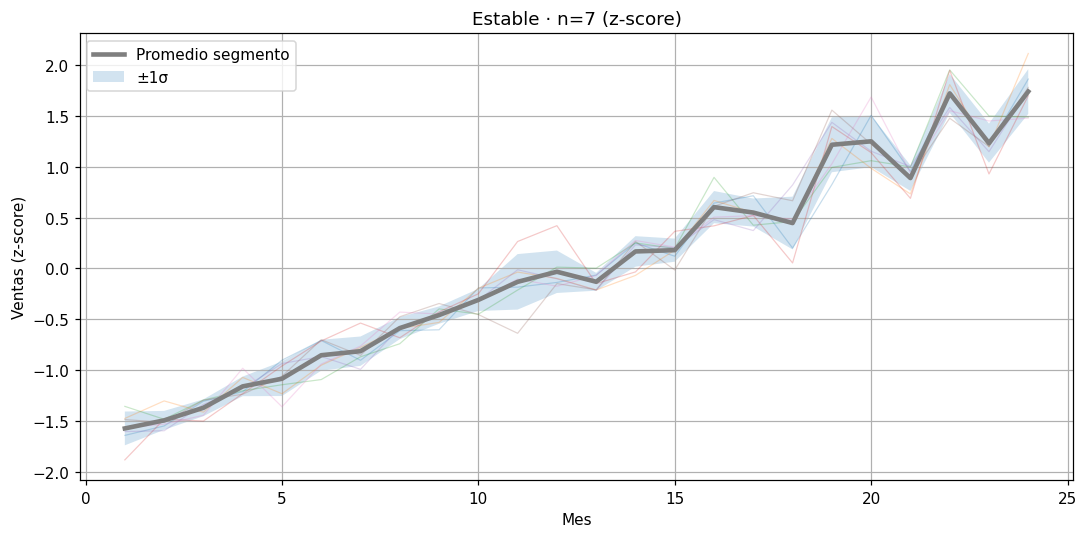

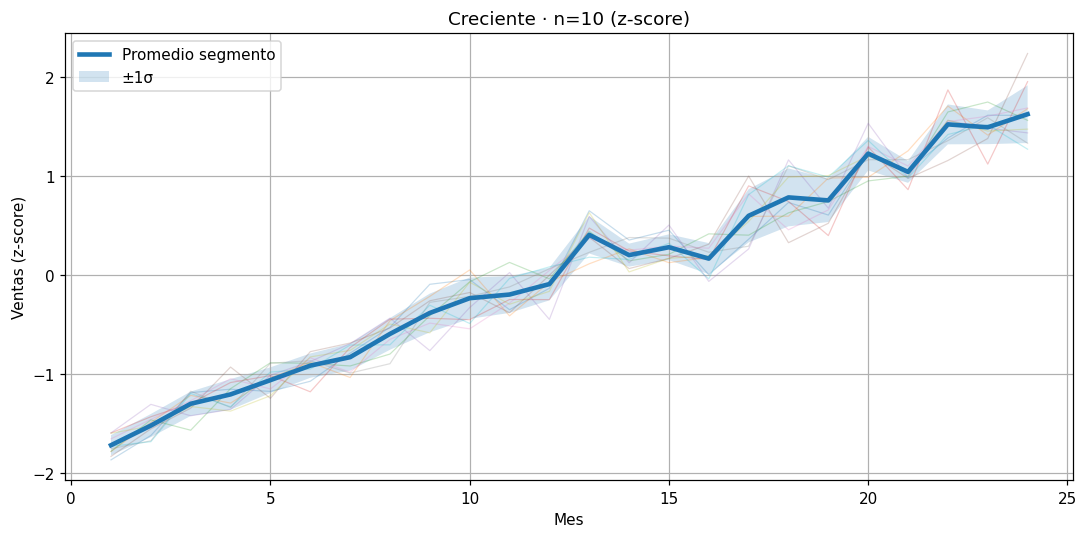

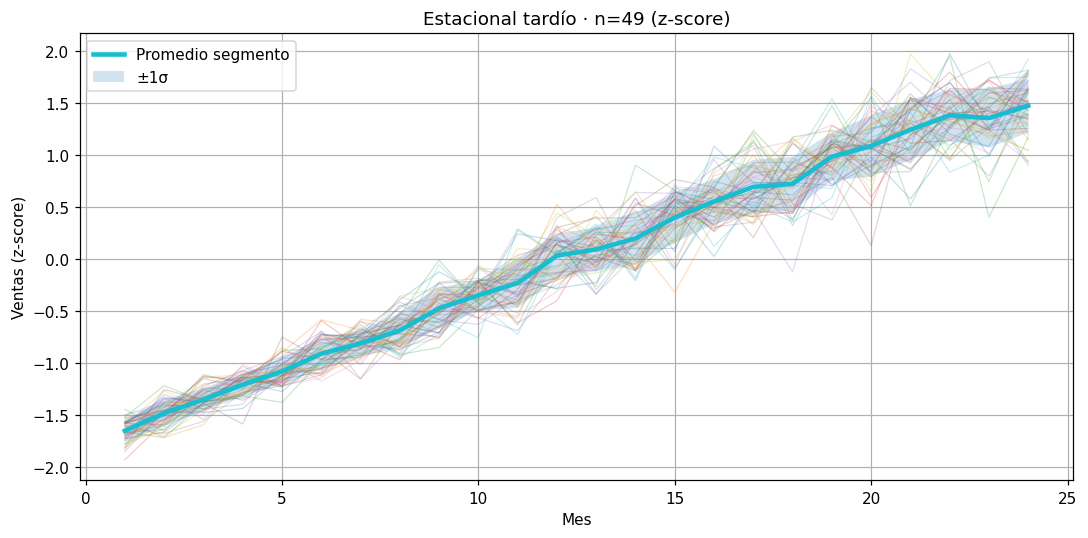

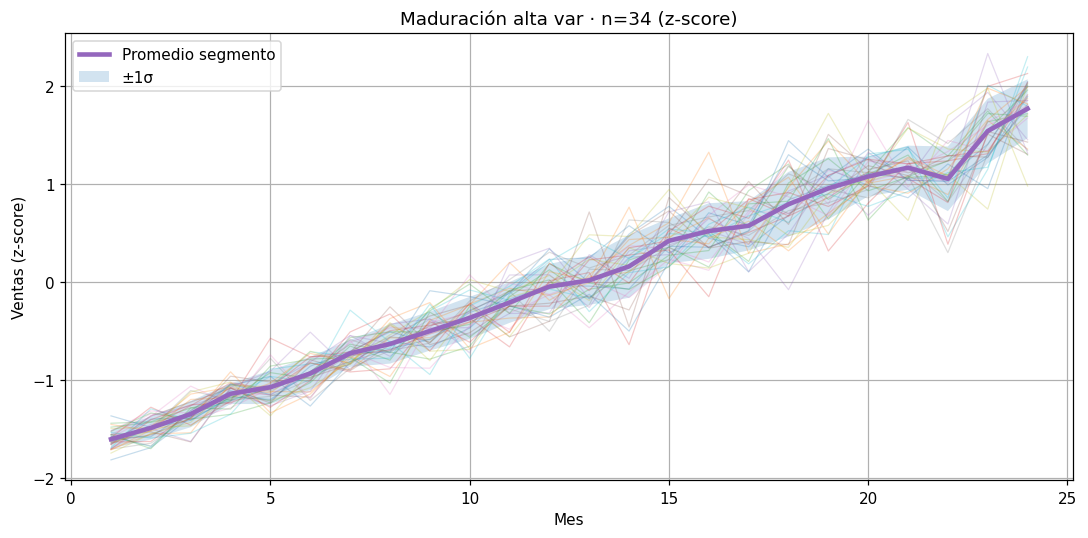

In [42]:
# Curvas por segmento (z-score): miembros en fino, promedio y banda ±1σ
import numpy as np
import matplotlib.pyplot as plt

seg_order = ["Estable", "Creciente", "Estacional tardío", "Maduración alta var"]
months = np.arange(1, len(month_cols)+1)

for seg in seg_order:
    sub = df_seg[df_seg["segmento_negocio"]==seg]
    mat = sub[month_cols].values
    avg = mat.mean(axis=0)
    std = mat.std(axis=0, ddof=1)

    plt.figure()
    # miembros
    for row in mat:
        plt.plot(months, row, linewidth=0.8, alpha=0.25)
    # promedio y banda
    plt.plot(months, avg, linewidth=3, label="Promedio segmento")
    plt.fill_between(months, avg-std, avg+std, alpha=0.2, label="±1σ")
    plt.title(f"{seg} · n={len(sub)} (z-score)")
    plt.xlabel("Mes")
    plt.ylabel("Ventas (z-score)")
    plt.legend()
    plt.tight_layout()
    plt.show()


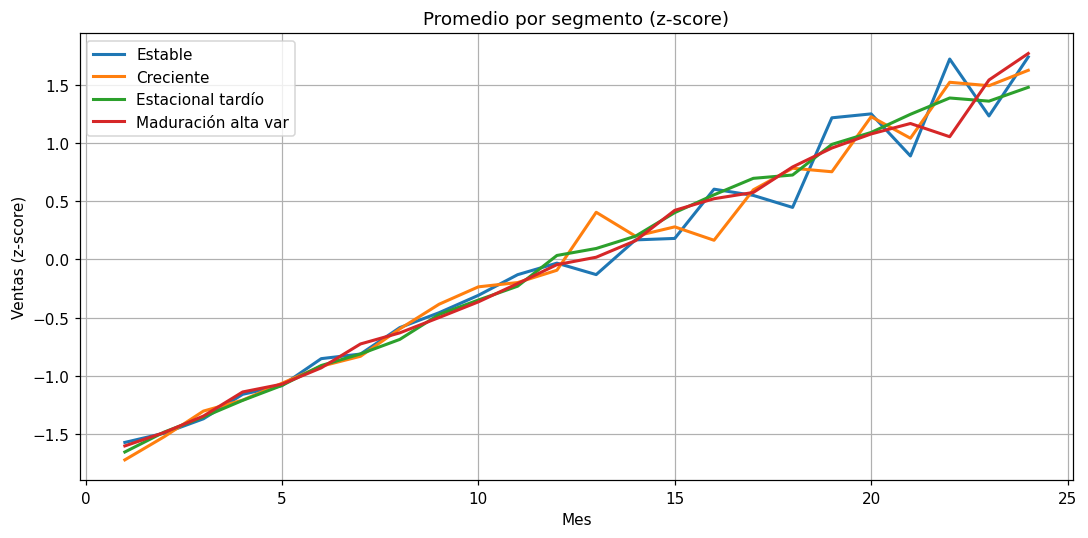

In [43]:
# Promedios por segmento (z-score) comparados en un solo gráfico
plt.figure()
for seg in seg_order:
    sub = df_seg[df_seg["segmento_negocio"]==seg]
    avg = sub[month_cols].values.mean(axis=0)
    plt.plot(months, avg, linewidth=2, label=seg)
plt.title("Promedio por segmento (z-score)")
plt.xlabel("Mes"); plt.ylabel("Ventas (z-score)")
plt.legend()
plt.tight_layout()
plt.show()


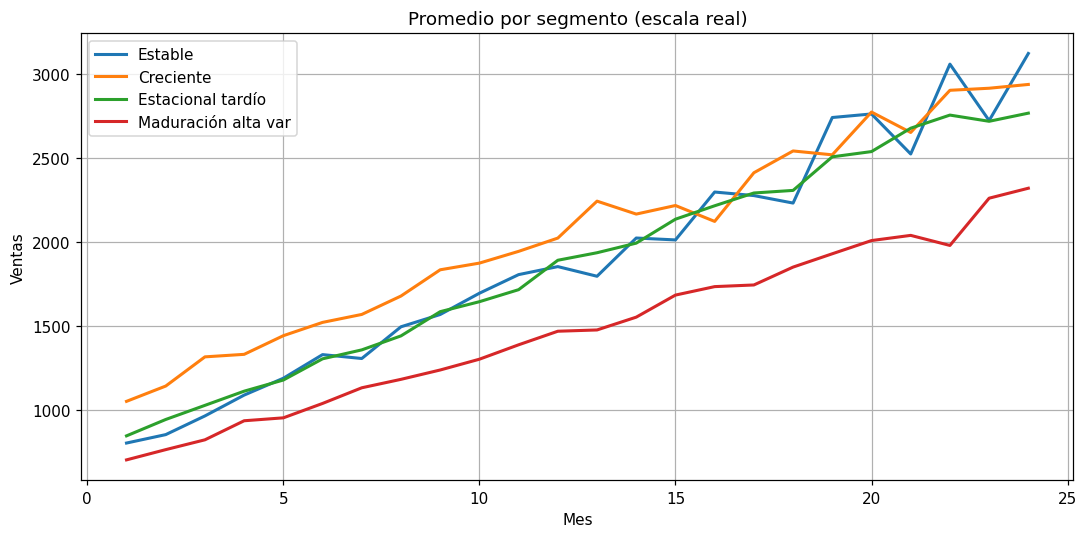

In [45]:
# Curvas promedio por segmento en ESCALA REAL (si wide_clean está disponible)
if 'wide_clean' in locals() and wide_clean is not None:
    clean_cols = [c for c in wide_clean.columns if c != "tienda"]
    months = np.arange(1, len(clean_cols)+1)

    plt.figure()
    for seg in seg_order:
        ids_seg = df_seg.loc[df_seg["segmento_negocio"]==seg, "tienda"]
        mat = (wide_clean[wide_clean["tienda"].isin(ids_seg)][clean_cols].values)
        avg = mat.mean(axis=0)
        plt.plot(months, avg, linewidth=2, label=seg)
    plt.title("Promedio por segmento (escala real)")
    plt.xlabel("Mes"); plt.ylabel("Ventas")
    plt.legend()
    plt.tight_layout()
    plt.show()


Grafica en escala real. Agradezco a CHATGPT por ayudarme a hacer el siguiente codigo porque no lo logre

- *Agradecimientos*

In [55]:
wide_clean.head(5)

Periodo,tienda,Mes_1,Mes_2,Mes_3,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,...,Mes_15,Mes_16,Mes_17,Mes_18,Mes_19,Mes_20,Mes_21,Mes_22,Mes_23,Mes_24
0,Tienda_1,371.564749,522.068486,521.880364,538.892196,679.219788,708.808632,850.909978,1000.226218,1118.401720,...,1203.011719,1651.064630,1494.530232,1497.056873,1483.004779,1604.220376,1427.213743,1649.712406,1813.670649,1969.643815
1,Tienda_2,447.247065,530.932667,678.064686,689.724767,682.211899,716.969313,813.394223,902.400432,1049.682847,...,1235.315618,1082.383150,1204.434377,1330.466538,1287.249417,1500.700850,1440.558516,1551.567342,1629.748407,1629.323937
2,Tienda_3,828.308926,904.216563,1089.587200,1255.467374,1189.656722,1405.482388,1497.697581,1616.418887,1552.245358,...,2389.627295,2193.004588,2140.718888,2333.918433,2620.599228,2517.798379,2442.790735,2650.604436,2499.033217,3157.325481
3,Tienda_4,211.314708,221.842367,241.279089,264.903623,288.745312,319.399635,309.789309,295.058906,312.727650,...,345.331855,410.768209,457.796846,489.905288,460.774025,515.471020,497.580795,469.935689,527.411501,523.747234
4,Tienda_5,989.848606,1062.300984,1066.981616,1293.887184,1257.499152,1255.806257,1408.963800,1562.594580,1484.318423,...,1969.898496,2059.243527,1939.642593,2199.284506,2414.607353,2219.556906,2253.555893,2167.031345,2508.872871,2377.258893


In [56]:
# --- rutas y carga ---
from pathlib import Path
import pandas as pd
import numpy as np


# columnas de meses
month_cols_clean = [c for c in wide_clean.columns if c != "tienda"]
months = np.arange(1, len(month_cols_clean)+1)

# --- construir df_seg si no existe ---
if 'df_seg' not in locals():
    # necesitas 'clusters' (labels del clustering sobre las mismas tiendas)
    # si no lo tienes en memoria, recomputa labels con tu Z/t elegido, o lee tu archivo clusters si lo guardaste.
    # Asumimos que ya tienes `clusters` con columnas ['tienda','cluster'] para k=8:
    assert 'clusters' in globals(), "No encuentro `clusters`. Cárgalo o recomputa los labels."
    
    # mapping del paso anterior (k=8 técnico -> 4 segmentos de negocio)
    mapping = {
        4: "Estacional tardío",
        5: "Estacional tardío",
        6: "Estacional tardío",
        1: "Maduración alta var",
        2: "Maduración alta var",
        8: "Maduración alta var",
        7: "Creciente",
        3: "Estable"
    }

    df_seg = wide_clean.merge(clusters, on="tienda", how="left")
    df_seg["segmento_negocio"] = df_seg["cluster"].map(mapping)

# orden sugerido
seg_order = ["Estable", "Creciente", "Estacional tardío", "Maduración alta var"]


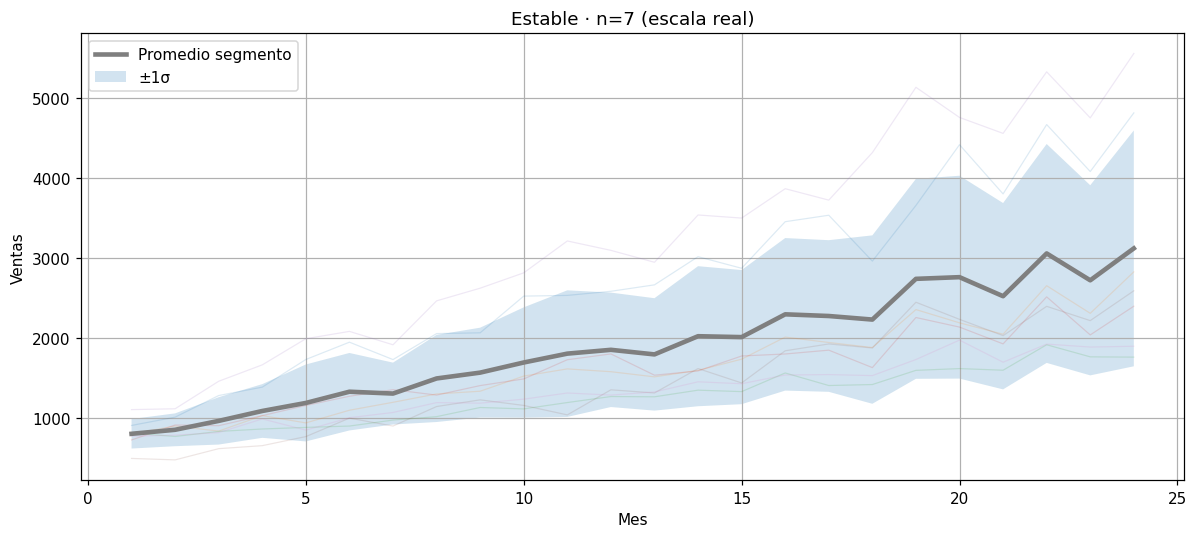

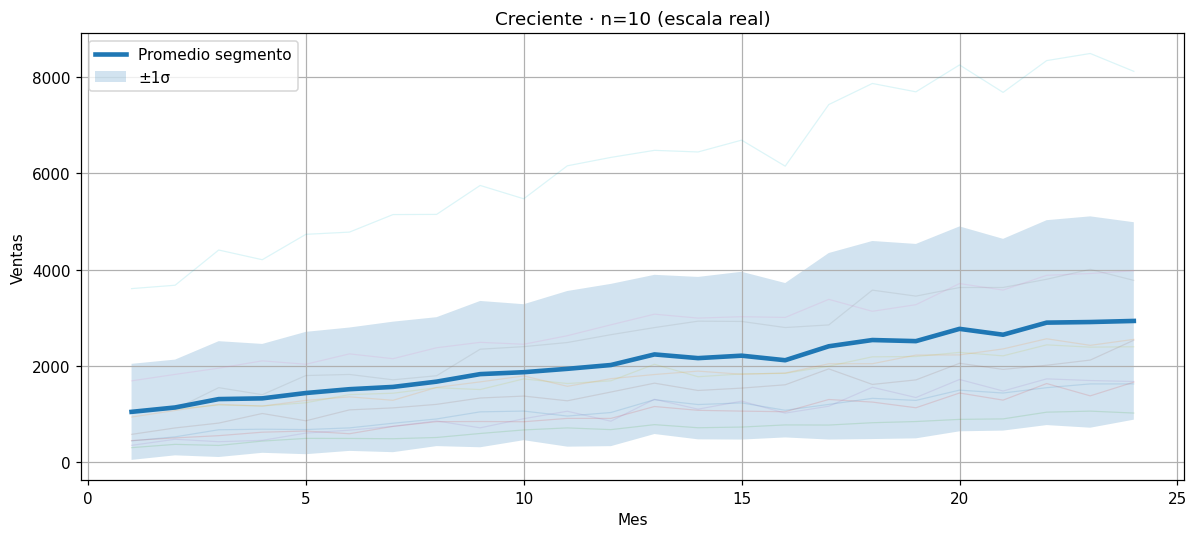

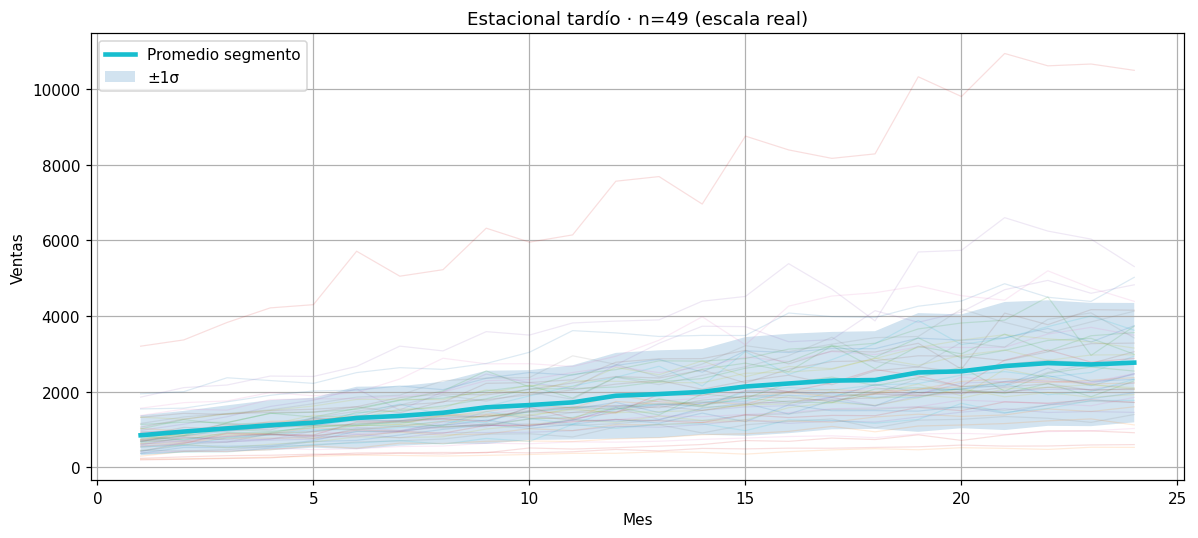

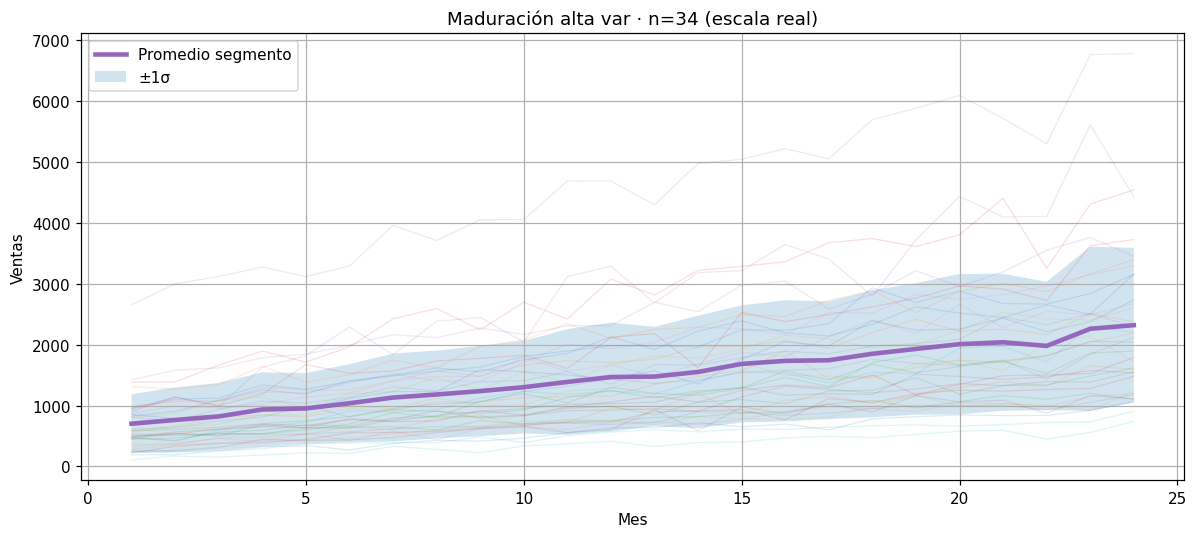

In [57]:
import matplotlib.pyplot as plt

for seg in seg_order:
    sub_ids = df_seg.loc[df_seg["segmento_negocio"]==seg, "tienda"]
    mat = wide_clean[wide_clean["tienda"].isin(sub_ids)][month_cols_clean].values
    avg = mat.mean(axis=0)
    std = mat.std(axis=0, ddof=1)

    plt.figure(figsize=(11,5))
    # miembros
    for row in mat:
        plt.plot(months, row, linewidth=0.8, alpha=0.15)
    # promedio y banda
    plt.plot(months, avg, linewidth=3, label="Promedio segmento")
    plt.fill_between(months, avg-std, avg+std, alpha=0.2, label="±1σ")
    plt.title(f"{seg} · n={mat.shape[0]} (escala real)")
    plt.xlabel("Mes"); plt.ylabel("Ventas")
    plt.legend()
    plt.tight_layout()
    plt.show()


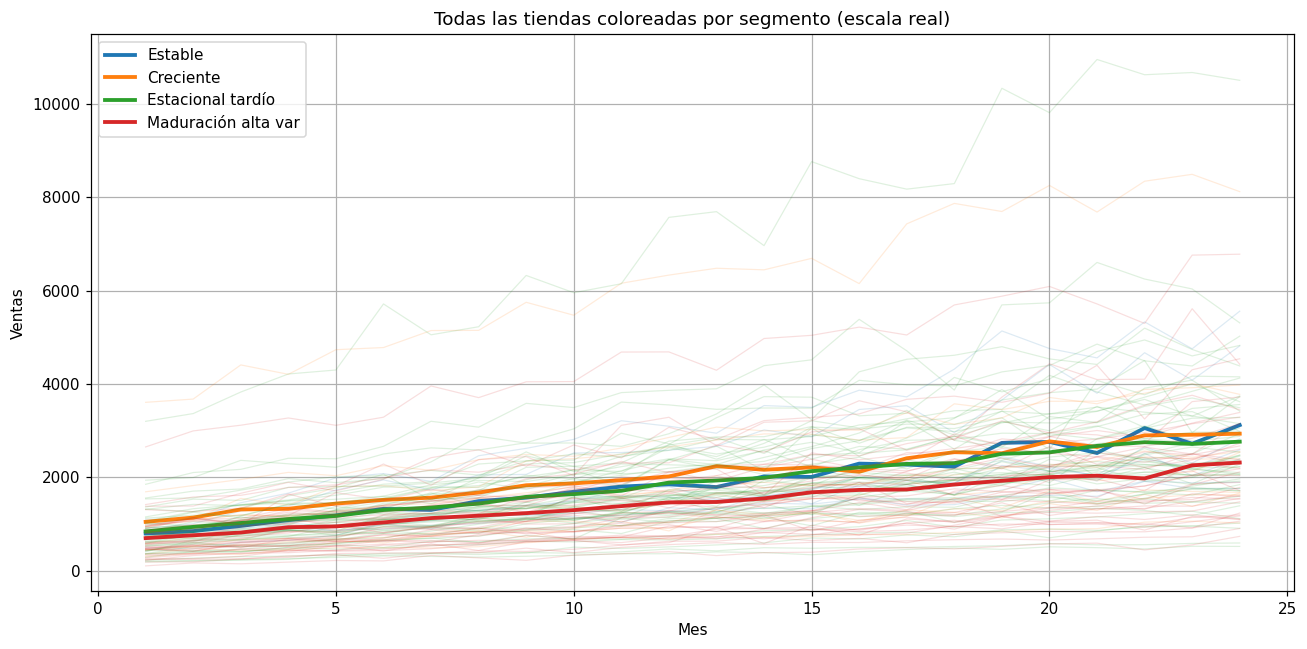

In [58]:
# paleta sencilla por segmento (puedes cambiar colores si quieres)
seg_colors = {
    "Estable": "#1f77b4",
    "Creciente": "#ff7f0e",
    "Estacional tardío": "#2ca02c",
    "Maduración alta var": "#d62728",
}

plt.figure(figsize=(12,6))
for seg in seg_order:
    sub = df_seg[df_seg["segmento_negocio"]==seg]
    mat = wide_clean[wide_clean["tienda"].isin(sub["tienda"])][month_cols_clean].values
    # todas las curvas del segmento
    for row in mat:
        plt.plot(months, row, linewidth=0.8, alpha=0.15, color=seg_colors[seg])
    # promedio del segmento para referencia
    avg = mat.mean(axis=0)
    plt.plot(months, avg, linewidth=2.5, color=seg_colors[seg], label=seg)

plt.title("Todas las tiendas coloreadas por segmento (escala real)")
plt.xlabel("Mes"); plt.ylabel("Ventas")
plt.legend()
plt.tight_layout()
plt.show()


Clúster vs segmento

- **Clúster** = resultado técnico del algoritmo (Ward+Euclidiana sobre z-score) con el resultado de 8–10 clústeres.

- **Segmento** = Lo aterrizamos al neogicó  (macro-segmentos) que consolida varios clústeres parecidos en pocas categorías accionables (4–5).

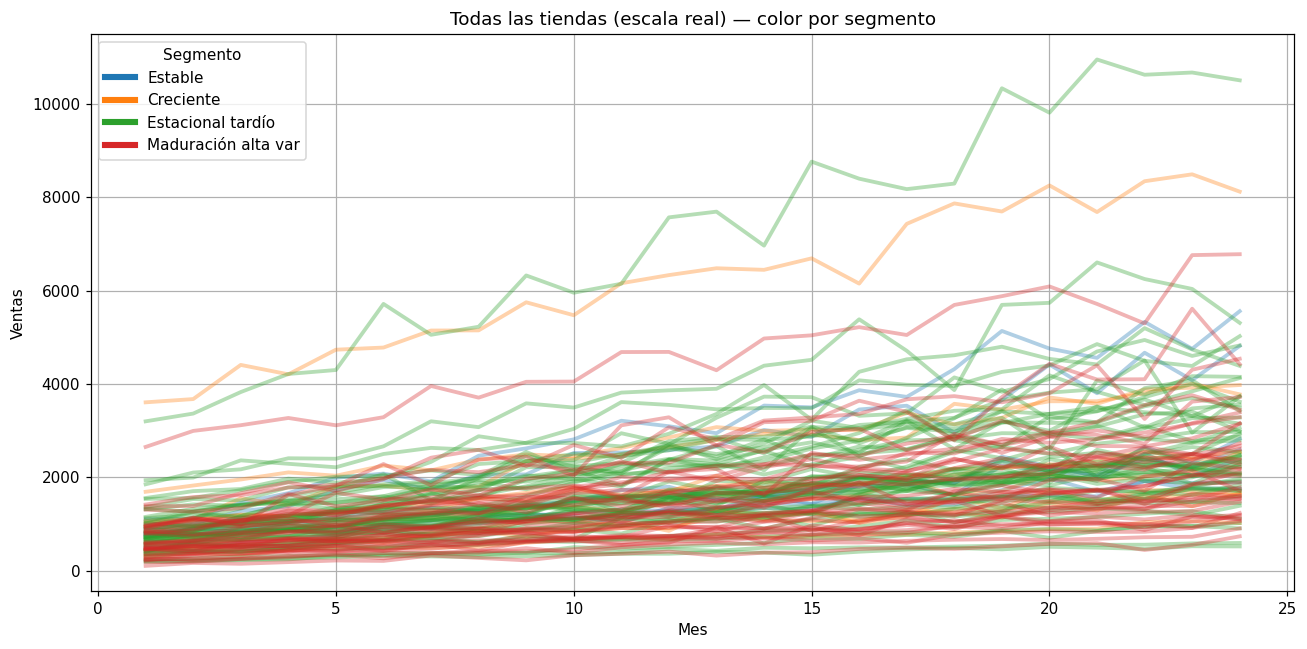

In [60]:
# ====== TODAS LAS TIENDAS COLOREADAS POR SEGMENTO (ESCALA REAL) ======
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# columnas de meses (escala real)
month_cols_clean = [c for c in wide_clean.columns if c != "tienda"]
months = np.arange(1, len(month_cols_clean)+1)

# paleta por segmento
seg_order  = ["Estable", "Creciente", "Estacional tardío", "Maduración alta var"]
seg_colors = {
  "Estable": "#1f77b4",
  "Creciente": "#ff7f0e",
  "Estacional tardío": "#2ca02c",
  "Maduración alta var": "#d62728",
}

plt.figure(figsize=(12,6))

# dibuja cada tienda con el color de su segmento y líneas más gruesas
for seg in seg_order:
  ids_seg = df_seg.loc[df_seg["segmento_negocio"]==seg, "tienda"]
  mat = wide_clean[wide_clean["tienda"].isin(ids_seg)][month_cols_clean].values
  for row in mat:
    plt.plot(months, row, linewidth=2.5, alpha=0.35, color=seg_colors[seg])

# leyenda de segmentos
handles = [Line2D([0],[0], color=seg_colors[s], lw=4, label=s) for s in seg_order]
plt.legend(handles=handles, title="Segmento", loc="upper left")

plt.title("Todas las tiendas (escala real) — color por segmento")
plt.xlabel("Mes"); plt.ylabel("Ventas")
plt.tight_layout()
plt.show()


Listo, k=8 y 4 segmentos me parecen perfecto

## Congelar resultados

In [65]:
from pathlib import Path
import pandas as pd
import numpy as np

# --- Carga robusta en escala real y asegura columna 'tienda' ---
def load_clean_with_tienda(fn: str | Path) -> pd.DataFrame:
    df = pd.read_csv(fn)
    # normaliza encabezados
    df.columns = [str(c).strip() for c in df.columns]

    # caso: archivo transpuesto (24 filas = meses; columnas Tienda_*)
    looks_transposed = (df.shape[0] == 24) and any(str(c).lower().startswith("tienda") for c in df.columns[1:])
    if looks_transposed:
        df = df.set_index(df.columns[0]).T.reset_index().rename(columns={"index": "tienda"})

    # si no existe 'tienda', intenta detectar o crear
    if "tienda" not in df.columns:
        cand = [c for c in df.columns if "tienda" in c.lower() or c.lower() in ("store","id")]
        if cand:
            df = df.rename(columns={cand[0]: "tienda"})
        else:
            # a veces la primera columna es índice "Unnamed: 0" con los IDs
            if df.columns[0].lower().startswith("unnamed"):
                df = df.rename(columns={df.columns[0]: "tienda"})
            else:
                # como último recurso, crea IDs sintéticos
                df.insert(0, "tienda", [f"Tienda_{i+1:03d}" for i in range(len(df))])

    # ordenar columnas: 'tienda' + meses
    month_cols = [c for c in df.columns if c != "tienda"]
    return df[["tienda"] + month_cols].copy()

# lee tu archivo (ajusta ruta si tu notebook está en /modelos)
wide_clean = load_clean_with_tienda("../data/clean/punto2/Punto2.ventas_funcionales_clean.csv")
month_cols_clean = [c for c in wide_clean.columns if c != "tienda"]

# --- Normaliza IDs en ambos dataframes antes del merge ---
def norm_id(s):
    s = str(s).strip().lower().replace(" ", "_")
    return s

wide_clean["__key__"] = wide_clean["tienda"].map(norm_id)
clusters["__key__"] = clusters["tienda"].map(norm_id)

df_seg = wide_clean.merge(clusters[["__key__","cluster"]], on="__key__", how="left").drop(columns="__key__")

# chequeo de emparejamiento
missing = int(df_seg["cluster"].isna().sum())
if missing > 0:
    print(f"⚠️ {missing} tienda(s) del CSV no emparejaron con clusters. Ejemplos:")
    print(df_seg[df_seg["cluster"].isna()]["tienda"].head().to_list())
else:
    print("✅ Todas las tiendas emparejaron con clusters.")

# mapeo a segmentos
mapping = {
    4: "Estacional tardío",
    5: "Estacional tardío",
    6: "Estacional tardío",
    1: "Maduración alta var",
    2: "Maduración alta var",
    8: "Maduración alta var",
    7: "Creciente",
    3: "Estable"
}
df_seg["segmento_negocio"] = df_seg["cluster"].map(mapping)



✅ Todas las tiendas emparejaron con clusters.


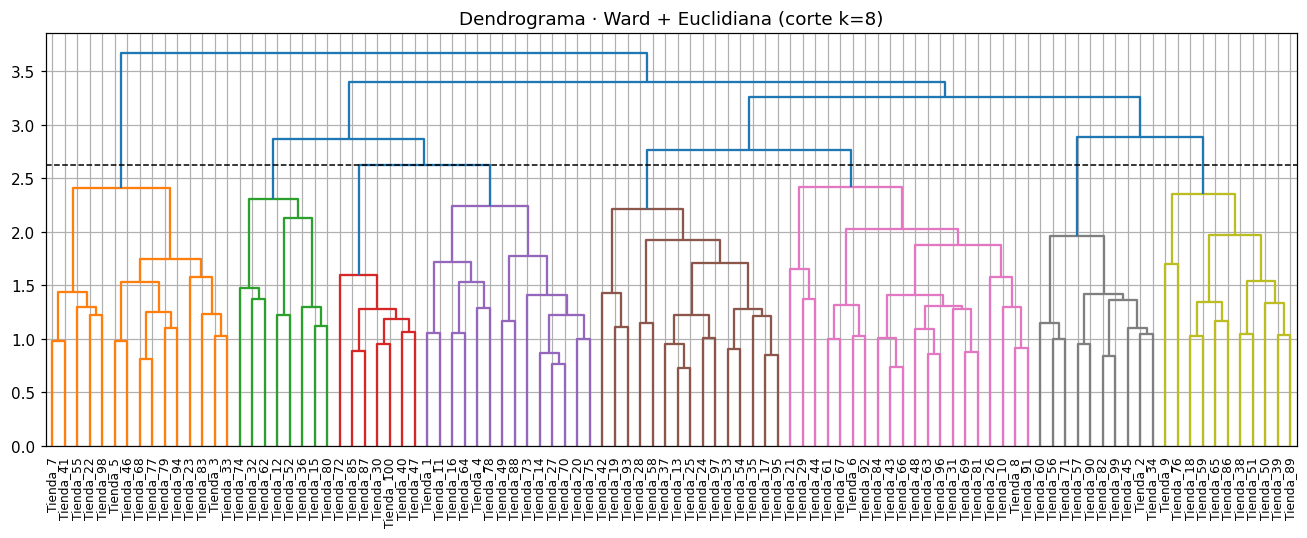

In [66]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

thr = Z[-(k_final-1), 2]  # altura de corte para k=8
plt.figure(figsize=(12,5))
dendrogram(Z, labels=ids, leaf_rotation=90, leaf_font_size=8, color_threshold=thr)
plt.axhline(thr, ls="--", c="k", lw=1)
plt.title(f"Dendrograma · Ward + Euclidiana (corte k={k_final})")
plt.tight_layout(); plt.show()


In [67]:
# Conteos y nivel (m24) por segmento
m24_col = month_cols_clean[-1]
n_tiendas = df_seg["segmento_negocio"].value_counts().rename("n_tiendas")
ventas_m24 = (df_seg[["tienda","segmento_negocio"]]
              .merge(wide_clean[["tienda", m24_col]], on="tienda")
              .groupby("segmento_negocio")[m24_col].mean()
              .rename("ventas_m24_avg"))
print(pd.concat([n_tiendas, ventas_m24], axis=1).sort_index().to_string())


                     n_tiendas  ventas_m24_avg
segmento_negocio                              
Creciente                   10     2936.629895
Estable                      7     3120.960527
Estacional tardío           49     2765.708488
Maduración alta var         34     2318.717471


## 5) Asignación de **Tienda_101** y proyección de 24 meses

ventas_m24_hat (Tienda_101) = 3019.705
Cluster elegido para Tienda_101: 7
 mes  venta_estimada
   1     1079.530221
   2     1173.180864
   3     1351.900125
   4     1367.326694
   5     1481.502862
   6     1562.915786
   7     1611.652342
   8     1724.357963
   9     1884.959798
  10     1925.855503
  11     1997.801873
  12     2079.092253
  13     2305.276861
  14     2226.041819
  15     2278.505661
  16     2181.159430
  17     2479.030162
  18     2612.466270
  19     2588.824826
  20     2850.730518
  21     2725.788612
  22     2983.888162
  23     2996.471994
  24     3019.705000


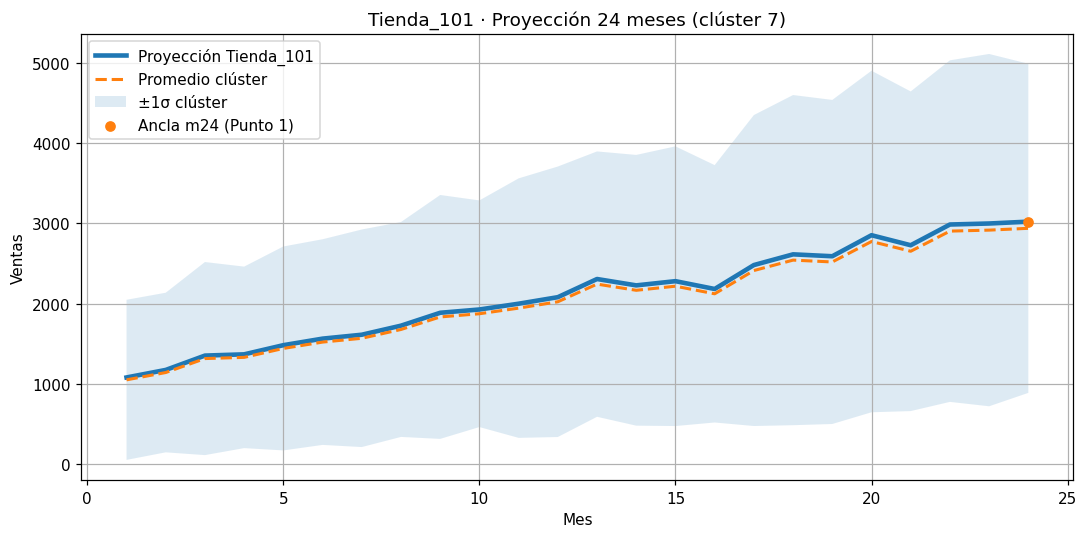

In [69]:
# === Leer predicción del Punto 1 ===
preds = pd.read_csv("./outputs_p1/pred_nuevas_tiendas.csv")
preds.columns = [c.strip().lower() for c in preds.columns]
id_col  = next(c for c in preds.columns if "tienda" in c)
# intenta detectar la columna de m24; ajusta si tu archivo usa otro nombre
m24_cols = [c for c in preds.columns if ("m24" in c) or ("ventas" in c and "24" in c)]
assert len(m24_cols)>=1, "No encuentro columna de m24 en pred_nuevas_tiendas.csv"
y_col = m24_cols[0]

row101 = preds[preds[id_col].astype(str).str.contains("101", case=False, regex=True)]
assert len(row101)==1, "No encuentro Tienda_101 en pred_nuevas_tiendas.csv"
yhat_24 = float(row101.iloc[0][y_col])
print("ventas_m24_hat (Tienda_101) =", yhat_24)

# === Elegir clúster para 101 por cercanía en m24 (escala real) ===
dfc = wide_clean.merge(clusters, on="tienda", how="left")
cluster_avg = (dfc.groupby("cluster")[month_cols_clean]
                 .mean()
                 .assign(m24=lambda d: d[m24_col]))
cid = int((cluster_avg["m24"] - yhat_24).abs().idxmin())
print("Cluster elegido para Tienda_101:", cid)

# === Proyección: curva promedio del clúster escalada a m24_hat ===
Cavg = cluster_avg.loc[cid, month_cols_clean].values
scale = yhat_24 / Cavg[-1] if Cavg[-1] != 0 else 1.0
yproj = Cavg * scale
proj = pd.DataFrame({"mes": np.arange(1, len(month_cols_clean)+1),
                     "venta_estimada": yproj})
print(proj.to_string(index=False))

# === Visual de la proyección con banda del clúster ===
mat = dfc[dfc["cluster"]==cid][month_cols_clean].values
avg = mat.mean(axis=0); std = mat.std(axis=0, ddof=1)

plt.figure(figsize=(10,5))
plt.plot(proj["mes"], proj["venta_estimada"], lw=3, label="Proyección Tienda_101")
plt.plot(np.arange(1,25), avg, lw=2, ls="--", label="Promedio clúster")
plt.fill_between(np.arange(1,25), avg-std, avg+std, alpha=0.15, label="±1σ clúster")
plt.scatter([24],[yhat_24], zorder=5, label="Ancla m24 (Punto 1)")
plt.title(f"Tienda_101 · Proyección 24 meses (clúster {cid})")
plt.xlabel("Mes"); plt.ylabel("Ventas")
plt.legend(); plt.tight_layout(); plt.show()



Con los datos obtenidos tenemos que **ventas_m24_hat = 3019.705** por lo que se asigna al **cluster 7** que es el cluster con una tendencia Cerciente por la cercania a el promedio o el **ancla m24**.

Notamos que tiene en la escala real **la forma tipica del cluster**

## 6) Validación (LOOCV-lite)

In [70]:

# Mide qué tan bien funciona "promedio del clúster escalado a m24" sobre un muestreo de tiendas conocidas
rng = np.random.default_rng(42)
sample_ids = rng.choice(dfc["tienda"], size=min(20,len(dfc)), replace=False)

maes, mapes = [], []
for tid in sample_ids:
    row = dfc[dfc["tienda"]==tid][month_cols_clean].values[0]
    true_m24 = row[-1]
    # asignar clúster por m24
    m24_by_cluster = dfc.groupby("cluster")[m24_col].mean()
    cl = (m24_by_cluster - true_m24).abs().idxmin()
    # proyección
    avg_curve = dfc[dfc["cluster"]==cl][month_cols_clean].values.mean(axis=0)
    scale = true_m24/avg_curve[-1] if avg_curve[-1]!=0 else 1.0
    pred = avg_curve*scale
    mae = np.mean(np.abs(pred - row))
    mape = np.mean(np.abs((pred-row)/np.clip(row,1e-6,None)))*100
    maes.append(mae); mapes.append(mape)

print(f"MAE promedio: {np.mean(maes):.1f} · MAPE promedio: {np.mean(mapes):.1f}%")



MAE promedio: 185.8 · MAPE promedio: 14.7%


Luego de asociarlo a uncluster hacer una validación rapida, nos da un error del 14.7% **razonable** al no tener tanta **planificación** por lo que identificarmos las formas y tendencias de forma correcta.

## 7) Exportables

In [ ]:

# %% [exports]
OUT_DIR = BASE_DIR / "outputs_p2"
OUT_DIR.mkdir(parents=True, exist_ok=True)

clusters.to_csv(OUT_DIR / "clusters_asignacion.csv", index=False)

# Curvas promedio por cluster
avg_df = []
for c, prof in profiles.items():
    row = {"cluster": c}
    for i, m in enumerate(month_cols, start=1):
        row[m] = prof["avg"][i-1]
    avg_df.append(row)
avg_df = pd.DataFrame(avg_df).sort_values("cluster")
avg_df.to_csv(OUT_DIR / "clusters_curvas_promedio.csv", index=False)

print("Guardado en:", OUT_DIR)
